In [100]:
import torchvision
from torchvision.datasets import CIFAR10
import torch
torch.manual_seed(0)


In [101]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
class MyDataset(Dataset):
   def __init__(self, np_file_paths):
        #self.data = torch.FloatTensor(data.values.astype('float'))
        self.files = os.listdir(np_file_paths)
        self.np_file_paths = np_file_paths
   def __getitem__(self, index):
     x = np.load("{}/{}".format(self.np_file_paths, self.files[index]))
     x = torch.from_numpy(x).float()
     label = torch.tensor(float(self.files[index].split("_")[4]))
     return x,label
   def __len__(self):
        return len(self.files)

        
#train_dataset = '/content/gdrive/"My Drive"/trainprob'
#test_dataset = '/content/gdrive/"My Drive"/testprob'


In [102]:
train_dataset =  MyDataset('/content/drive/MyDrive/trainprob/')
test_dataset = MyDataset('/content/drive/MyDrive/testprob/')
val_dataset = MyDataset('/content/drive/MyDrive/valueprob/')

In [103]:
train_dataset[12]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
       

In [104]:
print(len(val_dataset))

313


In [105]:

trainloader = DataLoader(train_dataset, batch_size = 64)
valloader = DataLoader(val_dataset, batch_size = 64)
testloader = DataLoader(test_dataset, batch_size = 64)

In [106]:
#у меня 22, а не 20
#сетка имеет один и тот же размер везде, будет плохо работать, количество входных выходных каналов #16 32 64  и обратно
import torch
import torch.nn as nn
class _Model(torch.nn.Module):
    """A neural network model to predict phylogenetic trees."""

    def __init__(self):
        """Create a neural network model."""
        super().__init__()
        self.conv = torch.nn.Sequential(
            torch.nn.Conv1d(88, 88, 1, groups=22),
            torch.nn.BatchNorm1d(88),
            torch.nn.ReLU(),
            torch.nn.Conv1d(88, 32, 1),
            torch.nn.BatchNorm1d(32),
            torch.nn.ReLU(),
            _ResidueModule(32),
            _ResidueModule(32),
            torch.nn.AvgPool1d(2),
            _ResidueModule(32),
            _ResidueModule(32),
            torch.nn.AvgPool1d(2),
            _ResidueModule(32),
            _ResidueModule(32),
            torch.nn.AvgPool1d(2),
            _ResidueModule(32),
            _ResidueModule(32),
            torch.nn.AdaptiveAvgPool1d(1),
            #torch.nn.Softmax(dim =-1)
        )
        self.classifier = torch.nn.Linear(32, 1)

    def forward(self, x):
        #x = torch.reshape(x.transpose(2,3),(x.size()[0], 88, -1))
        x = x.view(x.size()[0], 88, -1)
        x = self.conv(x).squeeze(dim=2)
        return self.classifier(x)
class _ResidueModule(torch.nn.Module):

    def __init__(self, channel_count):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Conv1d(channel_count, channel_count, 1),
            torch.nn.BatchNorm1d(channel_count),
            torch.nn.ReLU(),
            torch.nn.Conv1d(channel_count, channel_count, 1),
            torch.nn.BatchNorm1d(channel_count),
            torch.nn.ReLU()
            
        )

    def forward(self, x):
        return x + self.layers(x)

In [107]:
def validate(model,test_loader,device):
  correct = 0
  total = 0
  with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        output = model.forward(imgs) # get output
            #print(Y_pred)
        predicted=torch.sigmoid(output).squeeze()
        total += labels.shape[0] # all examples
            #print(labels.shape[0])
            #print(predicted.shape)
        correct += ((predicted>0.5) == labels).sum().item()
  
  return correct / total  

In [108]:
##непонятно, как писать train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # change run time to gpu to fast training

model = _Model().to(device)
#criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 10
loss_histtr = [] # for plotting
loss_histval = []
best_accuracyval = 0
best_accuracytr = 0
lossacctr = []
lossaccval = []
for epoch in range(num_epochs):
    model.train()
    hist_loss = 0
    hist_loss2 = 0
    for _, batch in enumerate(trainloader, 0): # get batch
        # parse batch 
        imgs, labels = batch
        imgs, labels = imgs.to(device), labels.to(device)
        # sets the gradients of all optimized tensors to zero.
        optimizer.zero_grad() 
        # get outputs
        Y_pred = model(imgs)
        Y_pred = Y_pred.squeeze(axis=1)
        #print(Y_pred.shape)
        #print(labels.shape)
        # calculate loss
        loss = criterion(Y_pred, labels)
        # calculate gradients
        loss.backward() 
        # performs a single optimization step (parameter update)
        optimizer.step()
        hist_loss += loss.item()
    accuracytr = validate(model,trainloader,device)  
    if best_accuracytr < accuracytr:
      best_accuracytr = accuracytr
    loss_histtr.append(hist_loss /len(trainloader))
    lossacctr.append(accuracytr)
    print(f"Epoch={epoch}  train_loss={loss_histtr[epoch]:.4f} accuracytr = {accuracytr:.4f}")
    model.eval()
    for _, batch2 in enumerate(valloader, 0): # get batch
        # parse batch 
        imgs2, labels2 = batch2
        imgs2, labels2 = imgs2.to(device), labels2.to(device)
        # sets the gradients of all optimized tensors to zero.
        # get outputs
        Y_pred2 = model(imgs2)
        Y_pred2 = Y_pred2.squeeze(axis=1)
       # print(Y_pred2.shape)
        #print(labels2.shape)
        # calculate loss
        loss2 = criterion(Y_pred2, labels2)
        hist_loss2 += loss2.item()
    accuracyval = validate(model,valloader,device)  
    if best_accuracyval < accuracyval:
      best_accuracyval = accuracyval
    lossaccval.append(accuracyval)
    loss_histval.append(hist_loss2 /len(valloader))
    print(f"Epoch={epoch}  val_loss={loss_histval[epoch]:.4f} accuracyval = {accuracyval:.4f}") 

Epoch=0  train_loss=0.8973 accuracytr = 0.3454
Epoch=0  val_loss=0.8170 accuracyval = 0.2780
Epoch=1  train_loss=0.7322 accuracytr = 0.5726
Epoch=1  val_loss=0.6890 accuracyval = 0.5335
Epoch=2  train_loss=0.6624 accuracytr = 0.6599
Epoch=2  val_loss=0.6307 accuracyval = 0.7188
Epoch=3  train_loss=0.6369 accuracytr = 0.6568
Epoch=3  val_loss=0.6071 accuracyval = 0.7220
Epoch=4  train_loss=0.6253 accuracytr = 0.6568
Epoch=4  val_loss=0.5963 accuracyval = 0.7252
Epoch=5  train_loss=0.6171 accuracytr = 0.6599
Epoch=5  val_loss=0.5906 accuracyval = 0.7252
Epoch=6  train_loss=0.6095 accuracytr = 0.6618
Epoch=6  val_loss=0.5864 accuracyval = 0.7284
Epoch=7  train_loss=0.6016 accuracytr = 0.6686
Epoch=7  val_loss=0.5837 accuracyval = 0.7316
Epoch=8  train_loss=0.5930 accuracytr = 0.6780
Epoch=8  val_loss=0.5815 accuracyval = 0.7380
Epoch=9  train_loss=0.5838 accuracytr = 0.6912
Epoch=9  val_loss=0.5795 accuracyval = 0.7444


Text(0, 0.5, 'loss')

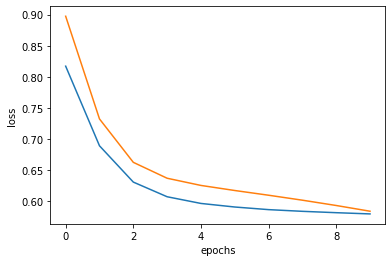

In [109]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(loss_histval)
plt.plot(loss_histtr)
plt.xlabel("epochs")
plt.ylabel("loss")

Text(0, 0.5, 'loss')

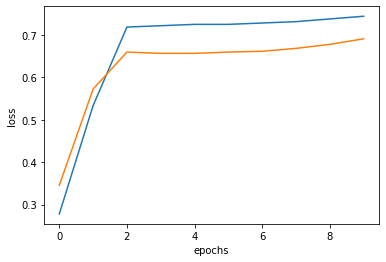

In [110]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(lossaccval)
plt.plot(lossacctr)
plt.xlabel("epochs")
plt.ylabel("loss")

In [111]:
def calaculate_accuracy(model, data_loader):
    correct, total = 0, 0 
    with torch.no_grad(): 
        for batch in data_loader: # get batch
            imgs, labels = batch # parse batch
            imgs, labels = imgs.to(device), labels.to(device)
            #print(imgs.shape)
            Y_pred = model.forward(imgs) # get output
            #print(Y_pred)
            predicted=torch.sigmoid(Y_pred).squeeze()
            print(predicted)
            total += labels.shape[0] # all examples
            #print(labels.shape[0])
            #print(predicted.shape)
            correct += ((predicted>0.5) == labels).sum().item() 
           # print(total,correct)
    return correct / total 

In [112]:

acc_train = round(calaculate_accuracy(model, trainloader), 3)
print(f"Accuracy train = {acc_train}")
acc_val = round(calaculate_accuracy(model, valloader), 3)
print(f"Accuracy val = {acc_val}")
acc_test = round(calaculate_accuracy(model, testloader), 3)
print(f"Accuracy test = {acc_test}")


tensor([0.2810, 0.2049, 0.2454, 0.2733, 0.2666, 0.3206, 0.4083, 0.2728, 0.2575,
        0.5433, 0.3313, 0.2799, 0.2125, 0.4659, 0.4057, 0.2328, 0.3646, 0.3265,
        0.2234, 0.2347, 0.2463, 0.2271, 0.5657, 0.2414, 0.4110, 0.3307, 0.3094,
        0.4333, 0.4556, 0.4639, 0.3841, 0.2834, 0.2872, 0.3618, 0.1894, 0.4679,
        0.2777, 0.2563, 0.4879, 0.3873, 0.4378, 0.2650, 0.3669, 0.4210, 0.4874,
        0.3952, 0.2542, 0.2972, 0.5220, 0.2826, 0.3349, 0.3683, 0.2888, 0.3043,
        0.3770, 0.3705, 0.4544, 0.2386, 0.4397, 0.2880, 0.4272, 0.2831, 0.4229,
        0.4174])
tensor([0.2387, 0.5175, 0.5807, 0.5090, 0.3553, 0.3539, 0.3740, 0.2598, 0.4682,
        0.3859, 0.3107, 0.4251, 0.2242, 0.3857, 0.2789, 0.4076, 0.3979, 0.5426,
        0.3358, 0.4533, 0.3606, 0.4317, 0.3710, 0.3907, 0.3342, 0.5051, 0.3330,
        0.1826, 0.3226, 0.3647, 0.4122, 0.3196, 0.2734, 0.2610, 0.3525, 0.3285,
        0.3691, 0.1324, 0.3086, 0.4957, 0.2542, 0.2481, 0.2474, 0.3419, 0.5178,
        0.2470, 0.2882,